# MNLI (Multi-genre Natural Language Interface)

## 🤔 해당 Notebook에서 수행할 것
- distilBERT 모델 구현
- DeBERTa-base 모델 구현
- 두 모델 비교

<br>

## ✅ 전체 워크플로우

### 1. dataset 준비
- Kaggle 이용 (`train`, `validation_matched`, `validation_mismatched`)   
  [![MNLI](https://img.shields.io/badge/Kaggle-MNLI-blue?logo=kaggle)](https://www.kaggle.com/datasets/thedevastator/unlocking-language-understanding-with-the-multin)
- MNLI란?   
  [![Notebook](https://img.shields.io/badge/Github-Preview-black?logo=github)](https://github.com/zerovodka/ML-learning/blob/master/src/week3/MNLI.ipynb)
  - 0: entailment (함의)
  - 1: neutral (중립)
  - 2: contradiction (모순)


In [1]:
import kagglehub

In [2]:
# Download latest version - kagglehub
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

# path 확인
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


**train/validation 데이터 전처리 및 로드**
- `class_label` function
  - dataset document에서 class label을 뽑는 방법을 못찾아서 직접 정의   
- `load_data` function
  - CSV 파일에서 데이터 로드
  - 빈 문장이 있는 행을 필터링: `keep_default_na=False`
  - dict 형식(`data`)으로 구조화한 리스트로 변환하여 리턴
    - pandas DataFrame이 아닌 **Python list of dict**
- train/validation 데이터 로드
  - 시간 절약을 위해 nrows 적용
  - shuffle ❌

In [3]:
import pandas as pd

In [4]:
def class_label(x):
  if x == 0:
    return 'entailment'
  elif x == 1:
    return 'neutral'
  elif x == 2:
    return 'contradiction'

def load_data(path, nrows=None):

  # path: CSV 파일 경로
  # nrows: 불러올 행의 개수 (맨 앞 ~ nrows 개수 만큼 읽어옴)
  # keep_default_na=False: NaN 처리를 하지 않음 => 빈 문자열에 대해 NaN 처리를 하지 않아 문자열 필터링에 유리
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)

  data = []

  # iterrows(): 각 행을 가르킨다
  # index, row이며, index는 사용하지 않으니 언더스코어 처리
  for _, row in df.iterrows():
    # premise 또는 hypothesis가 없으면 False 처리해버린다
    if len(row['premise']) * len(row['hypothesis']) != 0:
      # 아래와 같이 data에 dict 저장
      # {
      #   'premise': row['premise'],
      #   'hypothesis': row['hypothesis'],
      #   'label': row['label']
      # }
      data.append({
          'premise': row['premise'],
          'hypothesis': row['hypothesis'],
          'label': row['label'],
          'genre': row['genre'],
          'class': class_label(row['label'])
        })

  return data

**train dataset은 10배로 해보자 => 시간 너무 오래걸려서 줄여보자**   
- kaggle을 보니, train dataset의 크기가 굉장히 크다   
  - validation의 약 40배   
https://huggingface.co/datasets/nyu-mll/multi_nli/viewer/default/validation_matched?views%5B%5D=validation_matched

In [5]:
train_data = load_data(path+'/train.csv', nrows=1000)
test_data_matched = load_data(path+'/validation_matched.csv', nrows=500)
test_data_mismatched = load_data(path+'/validation_mismatched.csv', nrows=500)

**전처리 완료한 데이터 하나 찍어보기**

In [6]:
print(train_data[500]['premise'])
print(train_data[500]['hypothesis'])
print(train_data[500]['label'])
print(train_data[500]['genre'])
print(train_data[500]['class'])

' There were even days when I would wake up and think, 'Please God, let me die.
I had suffered severe depression during those days.
1
slate
neutral


In [7]:
from collections import Counter
Counter([d['label'] for d in train_data])

Counter({1: 282, 0: 343, 2: 375})

### 2. Pre-trained Model 선정 및 로드
- Hugging Face `transformers` 라이브러리 사용
  - `deberta-base`
  - `distillbert-base-uncased`

In [8]:
from transformers import AutoTokenizer, AutoModel

**모델/토크나이저 로드**   

In [9]:
# DistilBERT 모델
distilBERT = "distilbert-base-uncased"

# deBERTa-base 모델
deBERTa = "microsoft/deberta-base"

# Tokenizer
tokenizer_distilBERT = AutoTokenizer.from_pretrained(distilBERT)
tokenizer_deBERTa = AutoTokenizer.from_pretrained(deBERTa)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### 3. Tokenizer 및 Input 변환
- `Tokenizer`로 premise/hypothesis를 한 쌍으로 tokenization하기
  - `input_ids`
  - `attention_mask`
  - `token_type_ids`

**라이브러리**

In [10]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset

**PyTorch Dataset 구성**   
- 기존 전처리 데이터가 python dict 배열이었기 때문에

In [11]:
class MNLI_Dataset(Dataset):

  # max_length는 BERT류가 512이기에, 같은 2의 제곱수로 한단계 낮게 설정
  def __init__(self, data, tokenizer_name=None, max_length=256):
    self.data = data
    self.tokenizer = tokenizer_distilBERT if tokenizer_name == 'distilBERT' else tokenizer_deBERTa
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data[index]

    # 기존 collate_fn에서 하던 부분
    inputs = self.tokenizer(
        item['premise'],
        item['hypothesis'],
        padding='max_length',
        truncation=True,
        max_length=self.max_length,
        return_tensors='pt'
    )

    return {
        'input_ids': inputs['input_ids'].squeeze(0),
        'attention_mask': inputs['attention_mask'].squeeze(0),
        'label': torch.tensor(item['label'])
    }

### 4. 모델 정의 및 Fine-tuning
- Label 개수: 3
  - `Entailment`: 두 문장에 논리적 모순이 없다
  - `Neutral`: 두 문장은 논리적 연관성이 없다
  - `Contradiction`: 두 문장 사이에 논리적 모순이 있다

<br>

**모델 선정 기준**   
MNLI와 같은 NLU 태스크에 적절한 모델은 아래와 같은 조건을 만족해야함   
- 문장 쌍 처리 능력: 두 문장을 동시에 인코딩하고 관계 추론 가능
- 문맥 이해: 전체 문장 구조를 잘 이해하고 있어야 함(Bidirectional, Deep)
- 대규모 pre-training: 다양한 장르와 스타일을 학습한 경험이 있어야 MNLI 성능이 좋음
- 비교적 빠른 학습 속도: fine-tuning 실험 반복을 위해 중요

<br>

**모델 비교**   

|모델|구조 요약|장점|단점|MNLI 적합성|
|:--|:--|:--|:--|:--|
|DistilBERT|BERT를 경량화한 모델 (약 40% 작음)|빠른 속도, 적은 메모리 사용|성능 저하 (BERT 대비 3~5%↓), NLI 정밀도 낮음|⚠️ 적절하진 않음 (속도 위주 실험용)|
BERT-base-uncased|양방향 Transformer, 문장쌍 구조 처리 가능|안정적인 성능, 설명 풍부|최신 모델에 비해 느리고 성능 낮음|✅ 기본 실험에는 적절|
RoBERTa-base|BERT 확장 (dynamic masking, 더 많은 학습량)|NLI에서 강력한 성능 (MNLI SOTA 근접)	|token_type_ids 미사용 (문장쌍 명확히 구분하지 않음)|✅ 매우 적절 (정확도 높음)|
DeBERTa-base|상대적 위치 인코딩 + disentangled attention|문장 관계 파악 우수, MNLI 기준 최신 모델 중 상위권	|구조가 복잡하고 약간 느림|✅ 매우 적절 (MNLI leaderboard 상위)
ELECTRA-base|generator-discriminator 학습 구조|빠르고 효율적, BERT보다 가볍지만 성능 유사	|NLI에서 성능이 RoBERTa나 DeBERTa보다 떨어짐|⚠️ 보통 (속도 중시 시 고려 가능)|
ALBERT-base|BERT보다 작은 파라미터 + 파라미터 공유|메모리 효율 좋음, 성능은 유지|Fine-tuning 어려움, 안정성 떨어질 수 있음|⚠️ 실험적 사용은 가능하나 주력 아님



**pre-trained 모델**   
- dropout
- normalization 없음

In [12]:
class MNLIModel(nn.Module):
  def __init__(self, model_name, num_labels=3):
    super().__init__()
    self.select_bert = AutoModel.from_pretrained(model_name)
    self.classifier = nn.Linear(self.select_bert.config.hidden_size, num_labels)

  def forward(self, input_ids, attention_mask):
    outputs = self.select_bert(input_ids, attention_mask)
    cls_output = outputs.last_hidden_state[:, 0] # [CLS]
    logits = self.classifier(cls_output)
    return logits

### 5. 학습
- Loss: CrossEntropyLoss
- Optimizer: AdamW

**학습 전 준비**   
- Dataset
- DataLoader
- Model
- Optimizer
- Loss fn

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

############# Datasets
# DistilBERT Dataset
train_dataset_distilBERT = MNLI_Dataset(train_data, 'distilBERT')
val_dataset_distilBERT = MNLI_Dataset(test_data_matched, 'distilBERT')
test_dataset_distilBERT = MNLI_Dataset(test_data_mismatched, 'distilBERT')

# deBERTa-base Dataset
train_dataset_deBERTa = MNLI_Dataset(train_data, 'deBERTa')
val_dataset_deBERTa = MNLI_Dataset(test_data_matched, 'deBERTa')
test_dataset_deBERTa = MNLI_Dataset(test_data_mismatched, 'deBERTa')


############# DataLoaders
# DistilBERT DataLoader
train_dataloader_distilBERT = DataLoader(train_dataset_distilBERT, batch_size=16, shuffle=True)
val_dataloader_distilBERT = DataLoader(val_dataset_distilBERT, batch_size=16, shuffle=False)
test_dataloader_distilBERT = DataLoader(test_dataset_distilBERT, batch_size=16, shuffle=False)

# deBERTa-base DataLoader
train_dataloader_deBERTa = DataLoader(train_dataset_deBERTa, batch_size=16, shuffle=True)
val_dataloader_deBERTa = DataLoader(val_dataset_deBERTa, batch_size=16, shuffle=False)
test_dataloader_deBERTa = DataLoader(test_dataset_deBERTa, batch_size=16, shuffle=False)


############# Models
# DistilBERT Model
model_distilBERT = MNLIModel(distilBERT)
model_distilBERT.to(device)

# deBERTa-base Model
model_deBERTa = MNLIModel(deBERTa)
model_deBERTa.to(device)

############# Optimizers
optimizer_distilBERT = AdamW(model_distilBERT.parameters(), lr=1e-5)
optimizer_deBERTa = AdamW(model_deBERTa.parameters(), lr=1e-5)

############# loss
loss_fn = nn.CrossEntropyLoss()

**학습 함수 선언**   
- 학습 결과 시각화를 위한 history dict
- 정확도 함수
- 학습 함수

In [14]:
# 학습 결과 시각화를 위한 history
history = {
    distilBERT: {
      'train_loss': [],
      'val_loss': [],
      'test_loss': [],
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    },
    deBERTa: {
      'train_loss': [],
      'val_loss': [],
      'test_loss': [],
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    },
}

**Accuracy 함수 선언**

In [25]:
def accuracy(preds, labels, is_val=True):
  preds = torch.argmax(torch.tensor(preds), dim=-1)
  labels = torch.tensor(labels)
  return (preds == labels).float().mean()

In [16]:
def train(model, train_loader, optimizer, loss_fn, epochs=4, history={}):
  # train
  for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
      optimizer.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = model(input_ids, attention_mask)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    history['train_loss'].append(train_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}")



def validate(model, val_loader, loss_fn, history={}):
  # validation
  model.eval()
  val_loss = 0
  preds_val, labels_val = [], []
  with torch.no_grad():
    for batch in val_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = model(input_ids, attention_mask)
      loss = loss_fn(outputs, labels)
      val_loss += loss.item()

      preds_val.extend(torch.argmax(outputs, dim=1).tolist())
      labels_val.extend(labels.tolist())

  val_loss = val_loss / len(val_loader)
  val_acc = accuracy(preds_val, labels_val)

  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)

  print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


def test(model, test_loader, loss_fn, history={}):
  # test
  model.eval()
  test_loss = 0
  preds_test, labels_test = [], []
  with torch.no_grad():
    for batch in test_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = model(input_ids, attention_mask)
      loss = loss_fn(outputs, labels)
      test_loss += loss.item()

      preds_test.extend(torch.argmax(outputs, dim=1).tolist())
      labels_test.extend(labels.tolist())

  test_loss = test_loss / len(test_loader)
  test_acc = accuracy(preds_test, labels_test)

  history['test_loss'].append(test_loss)
  history['test_acc'].append(test_acc)

  print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


In [17]:
train(model_distilBERT, train_dataloader_distilBERT, optimizer_distilBERT, loss_fn, epochs=5, history=history[distilBERT])
train(model_deBERTa, train_dataloader_deBERTa, optimizer_deBERTa, loss_fn, epochs=5, history=history[deBERTa])

Epoch 1/5 | Train Loss: 1.0942
Epoch 2/5 | Train Loss: 1.0243
Epoch 3/5 | Train Loss: 0.8265
Epoch 4/5 | Train Loss: 0.5821
Epoch 5/5 | Train Loss: 0.3641
Epoch 1/5 | Train Loss: 1.1020
Epoch 2/5 | Train Loss: 1.0915
Epoch 3/5 | Train Loss: 1.1031
Epoch 4/5 | Train Loss: 1.1142
Epoch 5/5 | Train Loss: 1.1277


In [26]:
validate(model_distilBERT, val_dataloader_distilBERT, loss_fn, history=history[distilBERT])
validate(model_deBERTa, val_dataloader_deBERTa, loss_fn, history=history[deBERTa])

Val Loss: 1.0250 | Val Acc: 0.3020
Val Loss: 1.1063 | Val Acc: 0.3480


In [27]:
test(model_distilBERT, test_dataloader_distilBERT, loss_fn, history=history[distilBERT])
test(model_deBERTa, test_dataloader_deBERTa, loss_fn, history=history[deBERTa])

Test Loss: 0.9421 | Test Acc: 0.3680
Test Loss: 1.0957 | Test Acc: 0.3680


### 6. 평가 및 시각화
- Accuracy / Loss 커브
- Confusion Matrix 또는 F1 Score 분석
- Generalization: validation mismatched 데이터 확인

In [28]:
import matplotlib.pyplot as plt

In [30]:
print(history[distilBERT])

{'train_loss': [1.0942425254791501, 1.0243491710178436, 0.8264510896470811, 0.5820687824771518, 0.3641296646424702], 'val_loss': [1.025016481988132], 'test_loss': [0.9420864097774029], 'train_acc': [], 'val_acc': [tensor(0.3020)], 'test_acc': [tensor(0.3680)]}


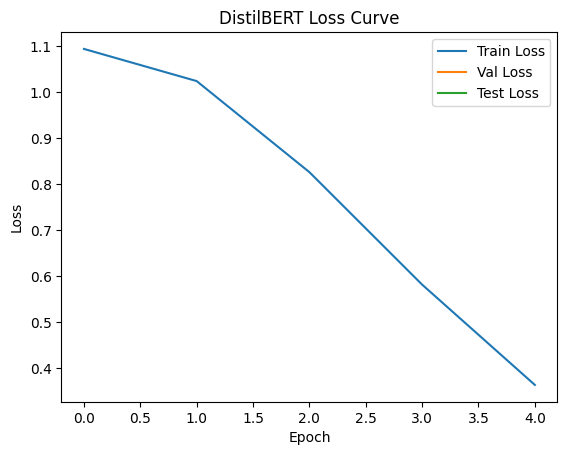

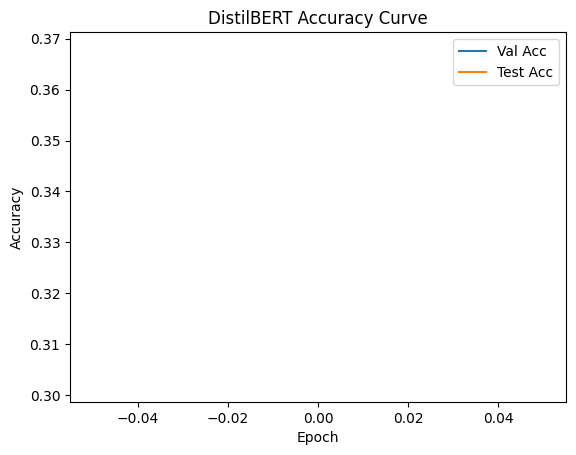

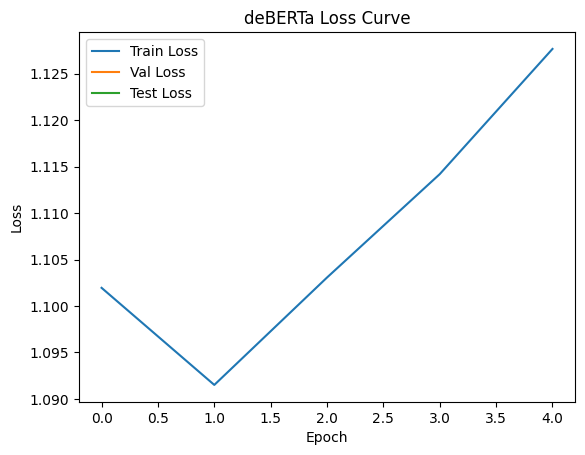

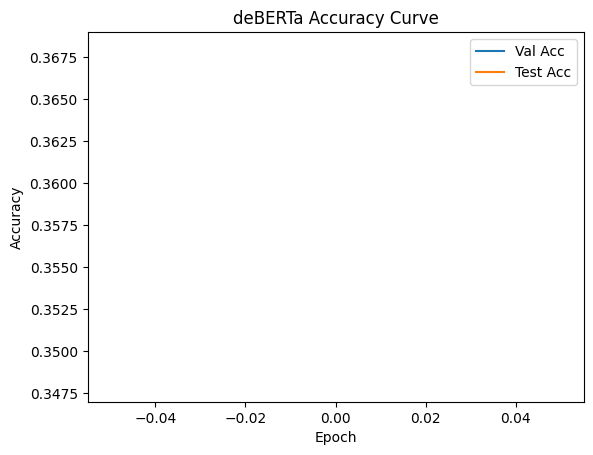

In [31]:
plt.plot(history[distilBERT]['train_loss'], label="Train Loss")
plt.plot(history[distilBERT]['val_loss'], label="Val Loss")
plt.plot(history[distilBERT]['test_loss'], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DistilBERT Loss Curve")
plt.legend()
plt.show()

plt.plot(history[distilBERT]['val_acc'], label="Val Acc")
plt.plot(history[distilBERT]['test_acc'], label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("DistilBERT Accuracy Curve")
plt.legend()
plt.show()

plt.plot(history[deBERTa]['train_loss'], label="Train Loss")
plt.plot(history[deBERTa]['val_loss'], label="Val Loss")
plt.plot(history[deBERTa]['test_loss'], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("deBERTa Loss Curve")
plt.legend()
plt.show()

plt.plot(history[deBERTa]['val_acc'], label="Val Acc")
plt.plot(history[deBERTa]['test_acc'], label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("deBERTa Accuracy Curve")
plt.legend()
plt.show()

### 7. Non-pre-trained Model로 동일 학습 수행하여 비교해보기
- 같은 데이터, 같은 하이퍼파라미터로 비교
- 성능 차이 분석